In [24]:
import pickle
import numpy
import keras
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

import h5py
import random
import numpy as np
from collections import defaultdict
from minibatcher import MiniBatcher
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
num_authors=40

### Full network definition
#### Note that this model goes all the way to the end.

In [3]:
model = Sequential()
model.add(Convolution2D(48, 12, 12,
                    border_mode='full',
                    input_shape=(1, 120, 120),
                    activation='relu'))
#model.add(Activation('relu'))

model.add(Convolution2D(48, 6, 6, activation='relu'))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, 6, 6, border_mode = 'full', activation='relu'))
#model.add(BN(epsilon=1e-6))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Convolution2D(128, 3, 3, border_mode = 'full', activation='relu'))
#model.add(BN(epsilon=1e-6))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


#model.add(Convolution2D(128, 6, 6, border_mode = 'full', activation='relu'))
#model.add(BN(epsilon=1e-6))
#model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_authors))
model.add(Activation('softmax'))

In [4]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [5]:
# weights = h5py.File('authors_40_forms_per_author_15_epoch_8100.hdf5.hdf5')
model.load_weights('/work/data/authors_40_forms_per_author_15_epoch_8100.hdf5.hdf5')

### Data shingling software written by Yonas

In [7]:
hdf5_file = '/work/data/output_shingles_sparse.hdf5'

num_forms_per_author=15
fIn = h5py.File(hdf5_file, 'r')
authors = []

# Filter on number of forms per author
for author in fIn.keys():
    if len(fIn[author]) > num_forms_per_author:
        authors.append(author)

if len(authors) < num_authors:
    raise ValueError("There are only %d authors with more than %d forms"%(len(authors), num_forms_per_author))


keys = []
# Get all the keys from our hdf5 file
for author in authors[:num_authors]: # Limit us to num_authors
    forms = list(fIn[author])
    for form in forms[:num_forms_per_author]: # Limit us to num_form_per_author
        for line_name in fIn[author][form].keys():
            for shingle in range(fIn[author][form][line_name].shape[0]):
                keys.append([(author,form,line_name), shingle])

# Normalization function which scales values from 0 (white) to 1 (black)
normalize = lambda x: 1.0 - x.astype(np.float32)/255.0

m = MiniBatcher(fIn, keys,normalize=normalize, batch_size=32, min_shingles=20*7*num_forms_per_author)

m.batch_size = 32*20
m.set_mode(MiniBatcher.TEST)
[X_test, Y_test] = m.get_batch()
X_test = np.expand_dims(X_test, 1)
Y_test = to_categorical(Y_test, num_authors)
print 'test_size:', X_test.shape, Y_test.shape

m.batch_size = 32*100
m.set_mode(MiniBatcher.TRAIN)

Key Depth:  3
Sample Key: (u'a01', u'a01-000u', u'a01-000u-00.png')
test_size: (640, 1, 120, 120) (640, 40)


### Partial network generation function

In [61]:
def partialnetwork(model, layernum):
    ''' def partialnetwork(model, layernum):
          model: the original full model
          layernum: the last layer of the neural network that you want to evaluate
        
          returns partial_model: the resulting neural network
    '''
    
    for i,l in enumerate(model.layers):
        print str(i+1)+": "+str(l)
    print "You are looking at "+str(model.layers[layernum+1])
    
    if len(model.layers) < layernum:
        return model
    
    rmodel = Sequential()
    for i in xrange(layernum):
        rmodel.add(model.layers[i])
        rmodel.layers[i].set_weights( model.layers[i].get_weights() )
    
    rmodel.compile(loss='mse', optimizer='adadelta')
    return rmodel

In [63]:
rmodel = partialnetwork(model, 7)

1: <keras.layers.convolutional.Convolution2D object at 0x7f96fef1a710>
2: <keras.layers.convolutional.Convolution2D object at 0x7f96fef1a850>
3: <keras.layers.convolutional.MaxPooling2D object at 0x7f96fef40e10>
4: <keras.layers.core.Dropout object at 0x7f96fef1a890>
5: <keras.layers.convolutional.Convolution2D object at 0x7f96fef40f50>
6: <keras.layers.convolutional.MaxPooling2D object at 0x7f96fef49350>
7: <keras.layers.convolutional.Convolution2D object at 0x7f96fef40f90>
8: <keras.layers.convolutional.MaxPooling2D object at 0x7f96fef49810>
9: <keras.layers.core.Dropout object at 0x7f96fef49450>
10: <keras.layers.core.Flatten object at 0x7f96fef49950>
11: <keras.layers.core.Dense object at 0x7f96fef499d0>
12: <keras.layers.core.Activation object at 0x7f96fef49a10>
13: <keras.layers.core.Dropout object at 0x7f97447dc2d0>
14: <keras.layers.core.Dense object at 0x7f96fef49c50>
15: <keras.layers.core.Activation object at 0x7f96fef4dd50>
You are looking at <keras.layers.core.Dropout obje

### Forward propagation to get the activations of the network. Support for dense layers only

In [23]:
def forwardviz(model, mbatch, numbatches, verbosity=1):
    
    ''' def forwardviz(model, mbatch, numbatches, verbosity=1):
          model: the model to be vizualized (can be partial)
          mbatch: minibatcher from Yonas's code
          numbatches: number of batches to run (stopping point)
          verbosity: verbosity in evaluating individual batches
          
          returns activations.
        
        Get the forward activations of model, using
        large scale modeling with data from minibatcher mbatch
    '''
    for i in range(numbatches):
        print "Loading data into memory & GPUs"
        (X_train, Y_train) = mbatch.get_batch()
        X_train = np.expand_dims(X_train, 1)
        Y_train = to_categorical(Y_train, num_authors)
        print "Beginning forward propagation on batch "+str(i)
        activations = model.predict(X_train, verbose=verbosity)
        print "Progress = "+str( (i+0.01-0.01) / numbatches)
        
    return X_train, activations

### Forward propagation lite, so that we only need to pass in training data. Really only calls predict w/model.

In [65]:
def forward2viz(model, X_train, verbosity=1):
    
    ''' def forwardviz(model, mbatch, numbatches, verbosity=1):
          model: the model to be vizualized (can be partial)
          mbatch: minibatcher from Yonas's code
          numbatches: number of batches to run (stopping point)
          verbosity: verbosity in evaluating individual batches
          
          returns activations.
        
        Get the forward activations of model, using
        large scale modeling with data from minibatcher mbatch
    '''
    activations = model.predict(X_train, verbose=verbosity)

    return activations

In [67]:
(X_train, Y_train) = m.get_batch()
X_train = np.expand_dims(X_train, 1)
Y_train = to_categorical(Y_train, num_authors)
activations = forward2viz(rmodel, X_train, verbosity=1)

640/640 [==============================] - 9s     


### Heatmap generation to get the most relevant portions of the image.

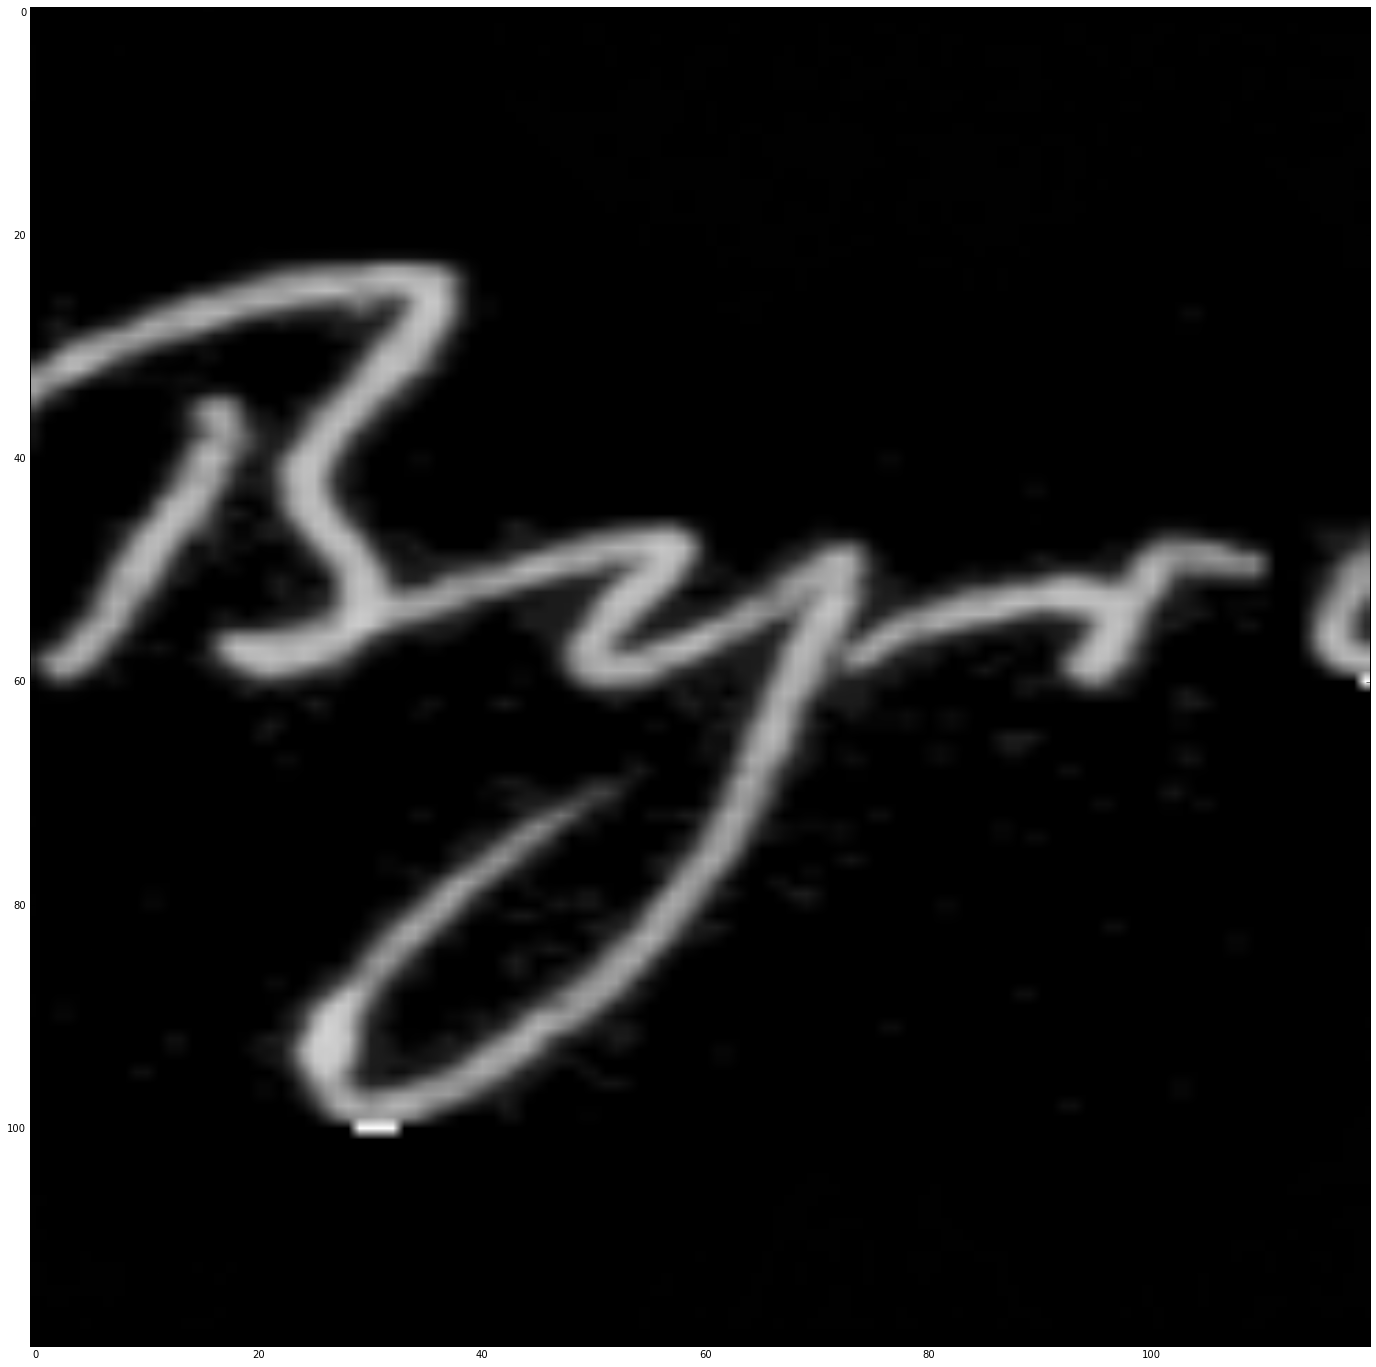

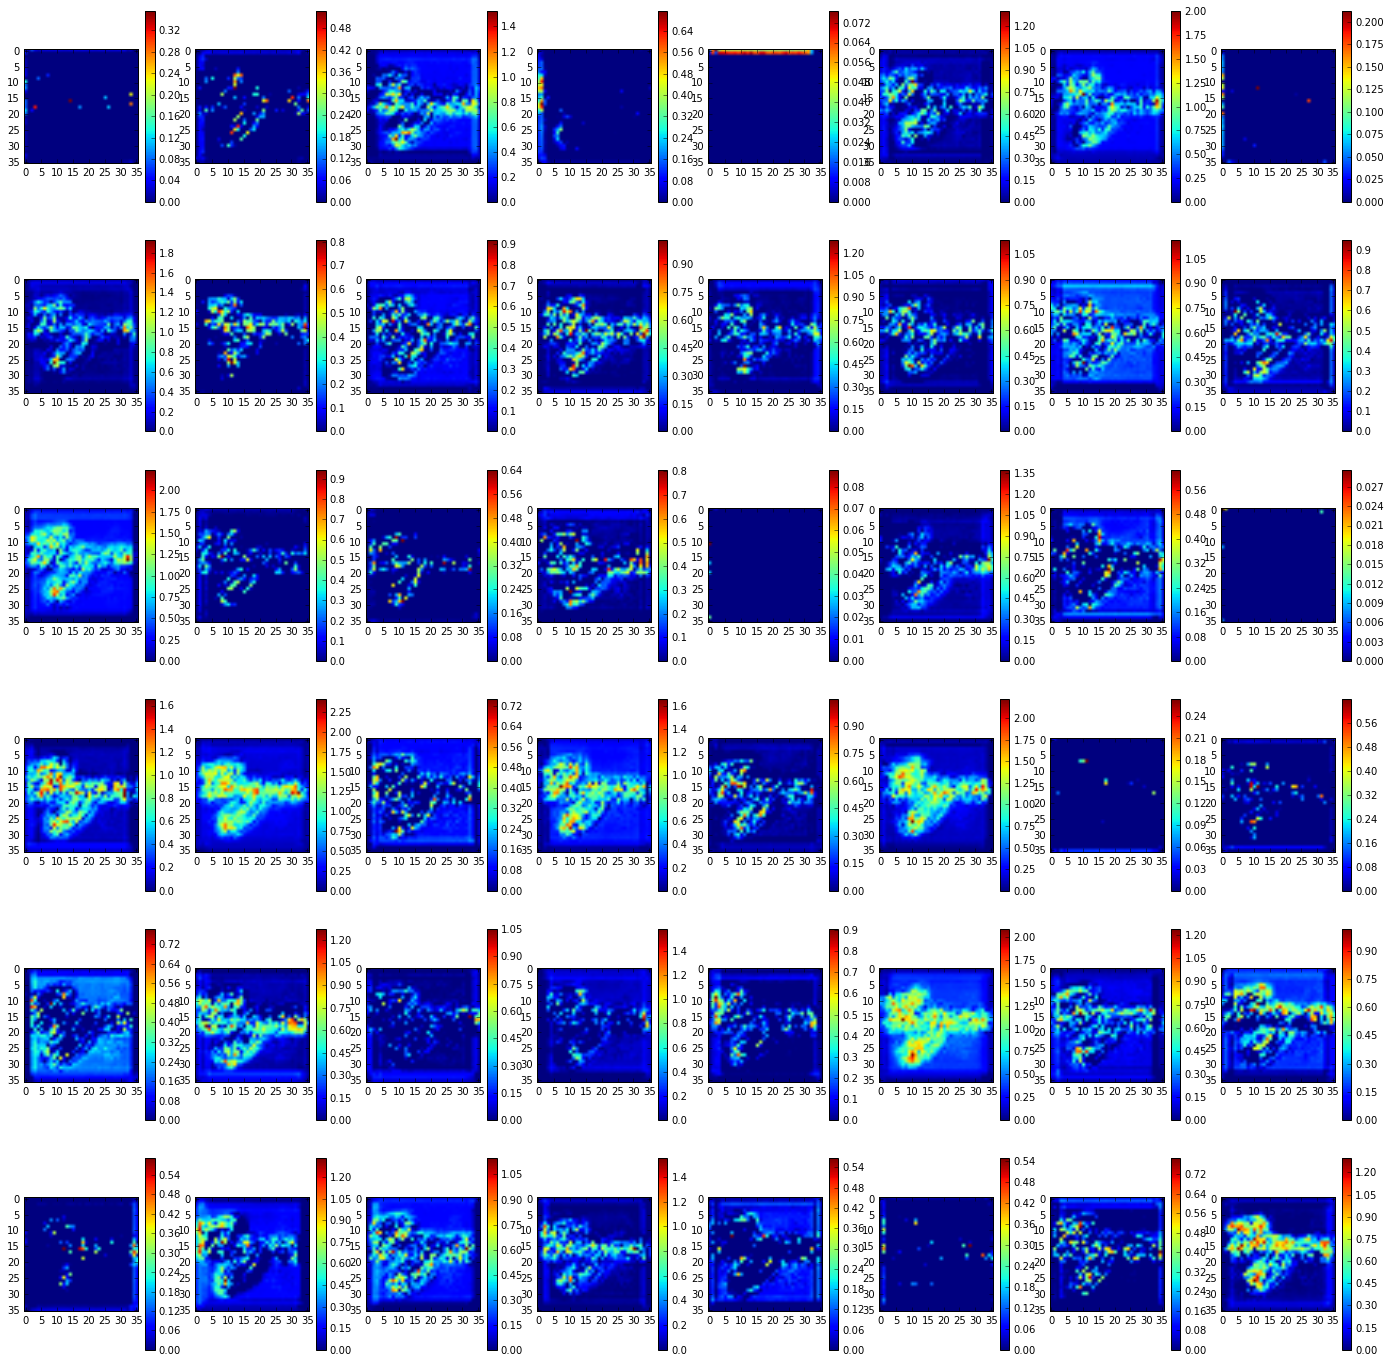

In [78]:
X_train.shape

# Image that we're looking at
i2look=3


plt.imshow(X_train[i2look,0], cmap=plt.get_cmap('gray'))
# plt.imshow(activations[i2look, 34])
plt.rcParams['figure.figsize'] = (24.0, 24.0)
fig, axs = plt.subplots(6,8)
for i in range(48):
    plt.subplot(6,8,i+1)
    plt.imshow(activations[i2look,i]) # , plt.get_cmap('gray'))
    plt.colorbar()


### Top activations for dense neuron